In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
G = ox.graph_from_place('Bangladesh', network_type='drive')

In [3]:
N, E = ox.graph_to_gdfs(G)

N = N.to_crs(3857)
E = E.to_crs(3857)

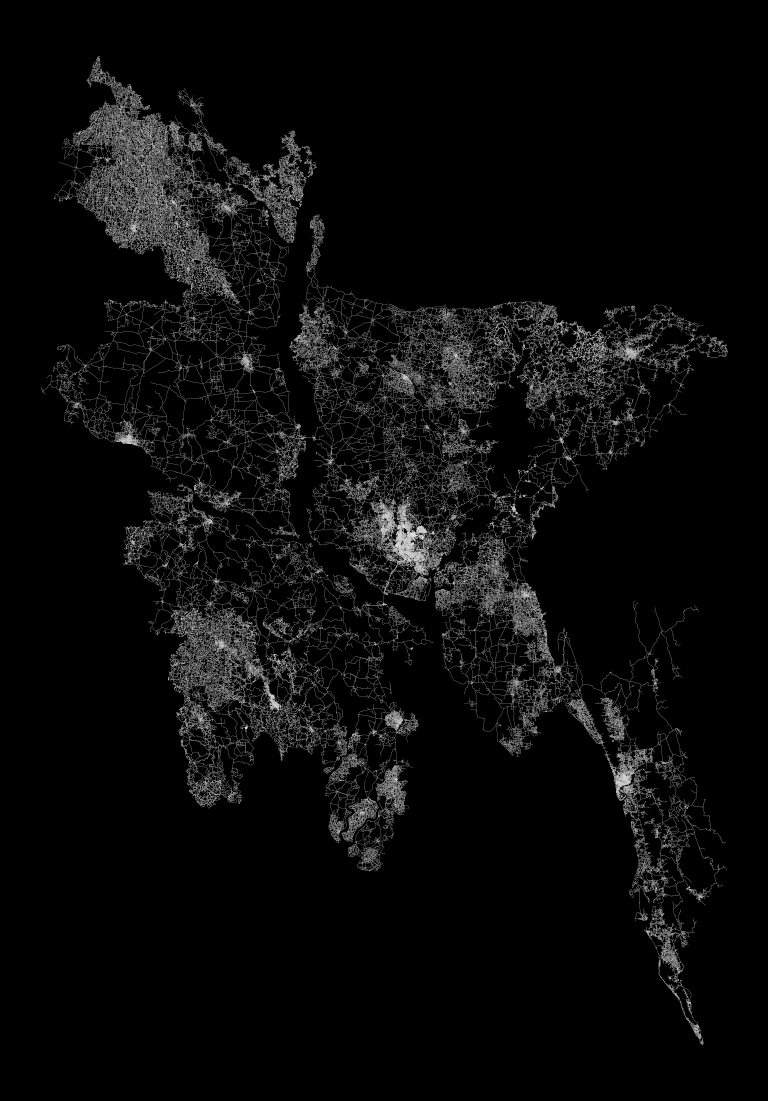

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.1)
ax.set_axis_off()
ax.set_facecolor('k')

In [32]:
E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].explore()

In [154]:
E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("পদ্মা সেতু")].explore()

In [56]:
dhaka = ox.geocoder.geocode("Dhaka, Bangladesh")
dhaka = ox.distance.nearest_nodes(G, dhaka[1], dhaka[0], return_dist=False)

In [59]:
from colorcet import palette
from matplotlib import colors

col = colors.LinearSegmentedColormap.from_list("bmw", palette['bmw'][::-1])

In [156]:
jamuna = E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].reset_index()
padma = E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("পদ্মা সেতু")].reset_index()

In [157]:
aoi_j = gpd.GeoDataFrame(geometry=gpd.GeoSeries(jamuna.geometry.unary_union.buffer(10000).envelope), crs=3857)
aoi_p = gpd.GeoDataFrame(geometry=gpd.GeoSeries(padma.geometry.unary_union.buffer(10000).envelope), crs=3857)

In [182]:
def cut_bridge(graph, bridge):
    
    graph = graph.copy()
    for i, r in bridge.iterrows():
        graph.remove_edge(r['u'], r['v'])
        
    return graph

In [183]:
# no jamuna
G_pre = cut_bridge(G, jamuna)

# no padma
G_pre = cut_bridge(G_pre, padma)

In [184]:
N_pre, E_pre = ox.graph_to_gdfs(G_pre)

E_pre = E_pre.to_crs(3857)
N_pre = N_pre.to_crs(3857)

In [185]:
%time pre_isolines = nx.single_source_dijkstra(G_pre, dhaka, weight='length')

CPU times: user 2.53 s, sys: 177 ms, total: 2.71 s
Wall time: 2.71 s


In [186]:
 pre_distances = pd.DataFrame({'osmid': pre_isolines[0].keys(), 'distance': pre_isolines[0].values()})

In [187]:
import mapclassify as mc

In [188]:
q10 = mc.Quantiles(pre_distances.distance, k=10)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E_pre.plot(color='k', linewidth=0.05, ax=ax)

N_pre.merge(pre_distances, 
            left_on='osmid', 
            right_on='osmid', 
            how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                         vmin=pre_distances.distance.min(),
                                         vmax=pre_distances.distance.max())

aoi_j.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)
aoi_p.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

ax.text(0.9, 0.9,
        "Before 1998",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )


ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...without Jamuna or Padma bridges.", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('bangladesh-1.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [191]:
# no padma
G_mid = cut_bridge(G, padma)

In [200]:
N_mid, E_mid = ox.graph_to_gdfs(G_mid)

E_mid = E_mid.to_crs(3857)
N_mid = N_mid.to_crs(3857)

In [201]:
%time mid_isolines = nx.single_source_dijkstra(G_mid, dhaka, weight='length')

CPU times: user 5.91 s, sys: 523 ms, total: 6.43 s
Wall time: 6.45 s


In [202]:
 mid_distances = pd.DataFrame({'osmid': mid_isolines[0].keys(), 'distance': mid_isolines[0].values()})

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E_mid.plot(color='k', linewidth=0.05, ax=ax)

N_mid.merge(mid_distances, 
            left_on='osmid', 
            right_on='osmid', 
            how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                         vmin=pre_distances.distance.min(),
                                         vmax=pre_distances.distance.max())

aoi_j.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

ax.text(0.9, 0.9,
        "After 1998",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...with Jamuna bridge.", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('bangladesh-2.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [214]:
%time post_isolines = nx.single_source_dijkstra(G, dhaka, weight='length')

CPU times: user 5.06 s, sys: 148 ms, total: 5.21 s
Wall time: 5.22 s


In [215]:
post_distances = pd.DataFrame({'osmid': post_isolines[0].keys(), 'distance': post_isolines[0].values()})

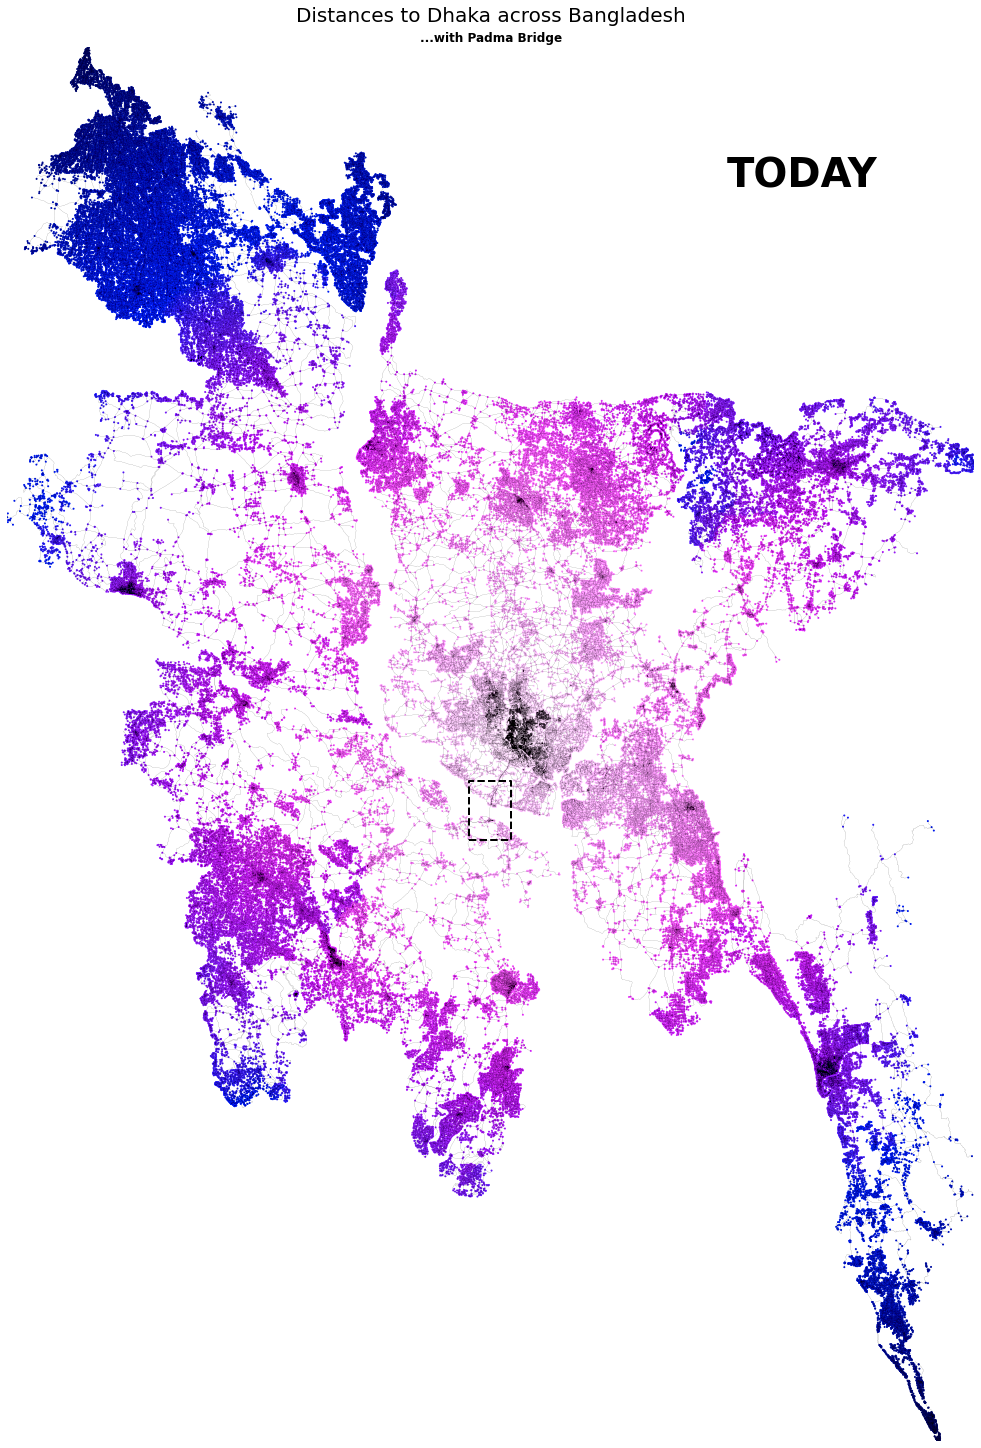

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E.plot(color='k', linewidth=0.05, figsize=(20, 20), ax=ax)

N.merge(post_distances, 
        left_on='osmid', 
        right_on='osmid', 
        how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                     vmin=pre_distances.distance.min(),
                                     vmax=pre_distances.distance.max())

aoi_p.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

ax.text(0.9, 0.9,
        "TODAY",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...with Padma Bridge", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('bangladesh-3.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [ ]:
import imageio
imgs = os.listdir("../viz/scenarios/")
imgs.sort()
imgs = [imageio.imread(f"../viz/scenarios/{x}") for x in imgs] 
imageio.mimsave("../viz/scenarios.gif", imgs, fps=0.5);